# [Segmenting customers of medical device manufacturer](https://app.datacamp.com/workspace/w/340ba6a8-af75-4ee0-99f5-cb1a22acffba)

## 1.1 Background

A medical device manufacturer in Switzerland manufactures orthopedic devices and sells them worldwide. The company sells directly to individual doctors who use them on rehabilitation and physical therapy patients. <br>
Historically, the sales and customer support departments have grouped doctors by geography. However, the region is not a good predictor of the number of purchases a doctor will make or their support needs. <br>
The team wants to use a data-centric approach to segmenting doctors to improve marketing, customer service, and product planning. 

## 1.2 Business Qustions

Before making a segmentation to the team, we shall focus on answering the following five business questions:
1. How many doctors are there in each region? What is the average number of purchases per region?
2. Can you find a relationship between purchases and complaints?
3. Define new doctor segments that help the company improve marketing efforts and customer service.
4. Identify which features impact the new segmentation strategy the most.
5. Describe which characteristics distinguish the newly defined segments.

## 2 The dataset

### 2.1 Imports

First, let's load all the modules that will be used in this report.

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from functools import reduce
import datetime, warnings
import missingno as msno
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

In [3]:
# Creates function to generate a data quality report
def dqr(df):
    """
    Generate a data quality report
    
    ARGS:
    df (dataframe): Pandas dataframe
    
    OUTPUT:
    dq_report: First few rows of dataframe, descriptive statistics, and other info such as missing data and unique values etc.
    """
    display(df.head())
    display(df.describe().round(1).T)
    
    # data type
    data_types = pd.DataFrame(df.dtypes, columns=['Data Type'])
  
    # missing data
    missing_data = pd.DataFrame(df.isnull().sum(), columns=['Missing Values'])

    # unique values
    unique_values = pd.DataFrame(columns=['Unique Values'])
    for row in list(df.columns.values):
        unique_values.loc[row] = [df[row].nunique()]
    
    # number of records
    count_values = pd.DataFrame(columns=['Records'])
    for row in list(df.columns.values):
        count_values.loc[row] = [df[row].count()]
        
    # join columns 
    dq_report = data_types.join(count_values).join(missing_data).join(unique_values)
  
    # percentage missing
    dq_report['Missing %'] = (dq_report['Missing Values'] / len(df) *100).round(2)
  
    # change order of columns
    dq_report = dq_report[['Data Type', 'Records', 'Unique Values', 'Missing Values', 'Missing %']]

    return dq_report

In [4]:
# Create function to display values on seaborn barplot
def show_values_on_bars(axs):
    """
    Display values on seaborn barplot
    
    ARGS:
    axs: seaborn barplot
    
    OUTPUT:
    Updates axs with values shown on barplot
    """
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 0.05
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [5]:
# Create function to remove outliers from dataframe
def remove_outliers(df):
    """
    Remove outliers from datafrome
    
    ARGS:
    df (dataframe): Pandas dataframe
    
    OUTPUT:
    Removes outliers greater than 1.5*IQR from numerical columns in dataframe
    """
    numerical = df.select_dtypes(include = ['int', 'Int64', 'float']).columns.tolist()
    for col_name in df[numerical]:
        q1 = df[col_name].quantile(0.25)
        q3 = df[col_name].quantile(0.75)
        iqr = q3 - q1
        low = q1 - 1.5 * iqr
        high = q3 + 1.5 * iqr
        df.loc[(df[col_name] < low) | (df[col_name] > high), col_name] = df[col_name].median()

### 2.2 Load data

Next, let's load the data and explore the basic contents for each dataframe: the type of the variables, whether there are null values.

### 💾 The data

The company stores the information you need in the following four tables. Some of the fields are anonymized to comply with privacy regulations.

#### Doctors contains information on doctors. Each row represents one doctor.

- "DoctorID" - is a unique identifier for each doctor.
- "Region" - the current geographical region of the doctor.
- "Category" - the type of doctor, either 'Specialist' or 'General Practitioner.'
- "Rank" - is an internal ranking system. It is an ordered variable: The highest level is Ambassadors, followed by Titanium Plus, Titanium, Platinum Plus, Platinum, Gold Plus, Gold, Silver Plus, and the lowest level is Silver.
- "Incidence rate"  and "R rate" - relate to the amount of re-work each doctor generates.
- "Satisfaction" - measures doctors' satisfaction with the company.
- "Experience" - relates to the doctor's experience with the company.
- "Purchases" - purchases over the last year.

#### Orders contains details on orders. Each row represents one order; a doctor can place multiple orders.

- "DoctorID" - doctor id (matches the other tables).
- "OrderID" - order identifier.
- "OrderNum" - order number.
- "Conditions A through J" - map the different settings of the devices in each order. Each order goes to an individual patient.

#### Complaints collects information on doctor complaints.

- "DoctorID" - doctor id (matches the other tables).
- "Complaint Type" - the company's classification of the complaints.
- "Qty" - number of complaints per complaint type per doctor.

#### Instructions has information on whether the doctor includes special instructions on their orders.

- "DoctorID" - doctor id (matches the other tables).
- "Instructions" - 'Yes' when the doctor includes special instructions, 'No' when they do not.

In [6]:
doctors = pd.read_csv('data/doctors.csv')
orders = pd.read_csv('data/orders.csv')
complaints = pd.read_csv('data/complaints.csv')
instructions = pd.read_csv('data/instructions.csv')

In [7]:
dqr(doctors)

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases
0,AHDCBA,4 15,Specialist,Ambassador,49.0,0.90,53.85,1.20,49.0
1,ABHAHF,1 8 T4,General Practitioner,Ambassador,37.0,0.00,100.00,0.00,38.0
2,FDHFJ,1 9 T4,Specialist,Ambassador,33.0,1.53,--,0.00,34.0
3,BJJHCA,1 10 T3,Specialist,Ambassador,28.0,2.03,--,0.48,29.0
4,FJBEA,1 14 T4,Specialist,Ambassador,23.0,0.96,76.79,0.75,24.0


,count,mean,std,min,25%,50%,75%,max
Incidence rate,437.0,5.0,4.2,2.0,3.0,4.0,6.0,49.0
R rate,437.0,1.1,0.7,0.0,0.6,1.0,1.5,4.2
Experience,437.0,0.5,0.6,0.0,0.1,0.4,0.8,5.4
Purchases,437.0,10.8,11.4,3.0,4.0,7.0,13.0,129.0


,Data Type,Records,Unique Values,Missing Values,Missing %
DoctorID,object,437,437,0,0.00
Region,object,437,46,0,0.00
Category,object,437,2,0,0.00
Rank,object,435,9,2,0.46
Incidence rate,float64,437,63,0,0.00
R rate,float64,437,137,0,0.00
Satisfaction,object,437,99,0,0.00
Experience,float64,437,106,0,0.00
Purchases,float64,437,45,0,0.00


In [8]:
dqr(orders)

,DoctorID,OrderID,OrderNum,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J
0,ABJEAI,DGEJFDC,AIBEHCJ,False,False,False,False,False,True,True,False,Before
1,HBIEA,DGAJDAH,AIJIHGB,False,True,NaN,False,False,True,False,True,Before
2,GGCCD,DGBBDCB,AFEIHFB,False,False,False,False,False,False,False,False,NaN
3,EHHGF,DGCDCCF,AIBJJEE,False,False,False,True,False,False,True,False,Before
4,EHHGF,DGCFAGC,AEDBBDC,False,False,False,False,False,False,False,False,NaN


,count,unique,top,freq
DoctorID,257,76,AAAEAH,19
OrderID,257,249,DFHACJH,2
OrderNum,257,248,AEFEHBC,2
Condition A,257,2,False,224
Condition B,257,2,False,221
Condition C,248,2,False,217
Condition D,257,2,False,223
Condition F,254,2,False,253
Condition G,254,2,False,208
Condition H,257,2,False,184


,Data Type,Records,Unique Values,Missing Values,Missing %
DoctorID,object,257,76,0,0.00
OrderID,object,257,249,0,0.00
OrderNum,object,257,248,0,0.00
Condition A,bool,257,2,0,0.00
Condition B,bool,257,2,0,0.00
Condition C,object,248,2,9,3.50
Condition D,bool,257,2,0,0.00
Condition F,object,254,2,3,1.17
Condition G,object,254,2,3,1.17
Condition H,bool,257,2,0,0.00


In [9]:
dqr(complaints)

,DoctorID,Complaint Type,Qty
0,EHAHI,Correct,10
1,EHDGF,Correct,2
2,EHDGF,Unknown,3
3,EHDIJ,Correct,8
4,EHDIJ,Incorrect,2


,count,mean,std,min,25%,50%,75%,max
Qty,435.0,1.8,1.6,1.0,1.0,1.0,2.0,15.0


,Data Type,Records,Unique Values,Missing Values,Missing %
DoctorID,object,435,284,0,0.00
Complaint Type,object,433,5,2,0.46
Qty,int64,435,12,0,0.00


In [10]:
dqr(instructions)

,DoctorID,Instructions
0,ADIFBD,Yes
1,ABHBED,No
2,FJFEG,Yes
3,AEBDAB,No
4,AJCBFE,Yes


,count,unique,top,freq
DoctorID,77,77,FCDID,1
Instructions,77,2,Yes,67


,Data Type,Records,Unique Values,Missing Values,Missing %
DoctorID,object,77,77,0,0.0
Instructions,object,77,2,0,0.0


## 3 Buisness Questions

The sales and customer support departments have previously grouped doctors by geography. Let's look into region information to see whether there are any signs that it is a good indicator.

### 3.1 How many doctors are there in each region?

We can find region information in the doctors table. Since each row represent one doctor, we then perform a groupby operation to count how many doctors there are in each region.

In [11]:
doctors_per_region = doctors.groupby('Region')['DoctorID'].count().reset_index().rename({"DoctorID": "Count"}, axis=1)
display(doctors_per_region.sort_values("Count", ascending=False).head())
display(doctors_per_region.describe())

,Region,Count
6,1 13,34
22,1 9,32
9,1 14,32
12,1 19,31
2,1 11,23


,Count
count,46.000000
mean,9.500000
std,9.008021
min,1.000000
25%,4.000000
50%,6.000000
75%,12.500000
max,34.000000


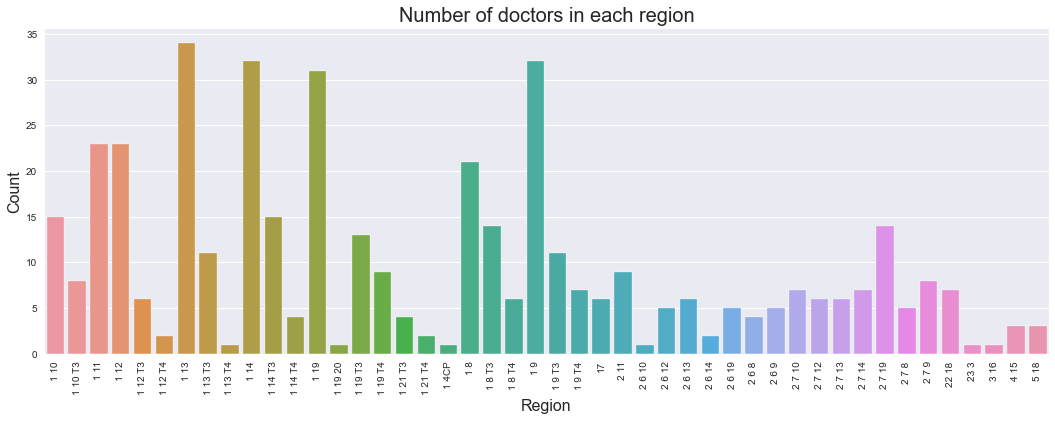

In [12]:
# Plot region vs count
plt.figure(figsize=(18,6))
ax = sns.barplot(x="Region", y="Count", data=doctors_per_region)
plt.xticks(rotation=90)
plt.xlabel("Region", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Number of doctors in each region", fontsize=20)
plt.show()

The barplot above compares the number of doctors in each region. Region `1 13` has the most number of doctors, followed by `1 9` and `1 14`. The counts range from 1 to 34. The mean number of doctors across all regions is `10`, while the median is `6`. There is no observerable direct relationship between number of doctors and region.

### 3.2 What is the average number of purchases per region?

We can find region and purchases information in the doctors table. We will perform a groupby operation to aggregate the average number of purchases in each region.

In [13]:
avg_purchases_per_region = doctors.groupby('Region')['Purchases'].mean().reset_index().rename({"Purchases": "Average purchases"}, axis=1)
display(avg_purchases_per_region.sort_values("Average purchases", ascending=False).head())
display(avg_purchases_per_region.describe())

,Region,Average purchases
13,1 19 20,129.000000
8,1 13 T4,30.000000
15,1 19 T4,25.333333
24,1 9 T4,23.428571
44,4 15,23.333333


,Average purchases
count,46.000000
mean,13.109296
std,18.662995
min,3.000000
25%,5.035714
50%,10.145722
75%,14.000000
max,129.000000


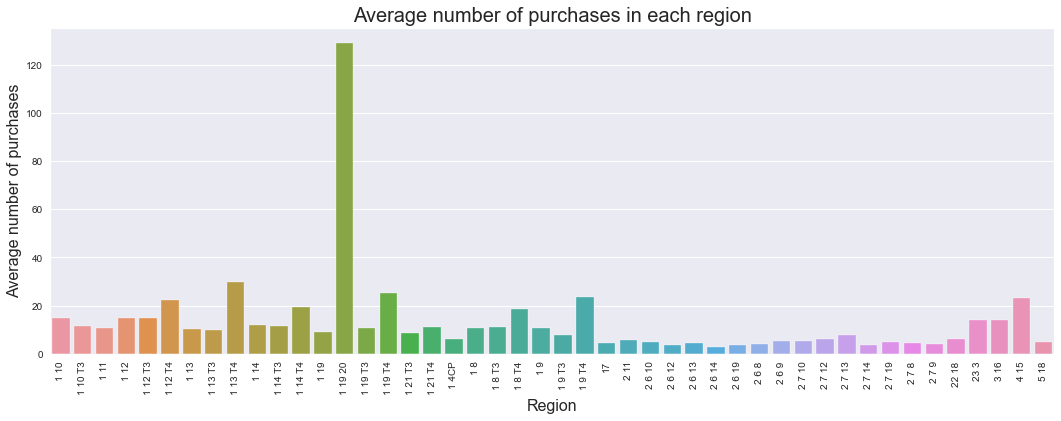

In [14]:
# Plot region vs average number of purchases
plt.figure(figsize=(18,6))
sns.barplot(x="Region", y="Average purchases", data=avg_purchases_per_region)
plt.xticks(rotation=90)
plt.xlabel("Region", fontsize=16)
plt.ylabel("Average number of purchases", fontsize=16)
plt.title("Average number of purchases in each region", fontsize=20)
plt.show()

The barplot above compares the average number of purchases in each region. Region `1 19 20` has the highest average number of purchases of 129, however it can also be treated as a outlier because it is much larger than the other values in the dataset. The next highest region is `1 13 T4` with 30 average purchases. The average number of purchases range from 3 to 129. Across the dataset, the mean number of purchases across all region is `13`, while the median is `10`. There is no observerable direct relationship between number of purchases and region.

### 3.3 Can you find a relationship between purchases and complaints?

Complaints information can be found complaints table. First let's sum the quantity of complaints to `DoctorID`, then merge the complaints table with doctors table. There are also outliers, which are data values that are far away from other data values, which can strongly affect results. We will remove these outliers and calculate the correlation between the two variables.

,DoctorID,Qty,Purchases
0,AAAEAH,1.0,20.0
1,AABDHC,1.0,10.0
2,AABGAB,4.0,4.0
3,AADDIG,1.0,5.0
4,AAEIEG,2.0,11.0


No. of instances where quantity of complaints were more than number of purchases 7
Correlation between purchases and quantity of complaints: 0.01839142745208687


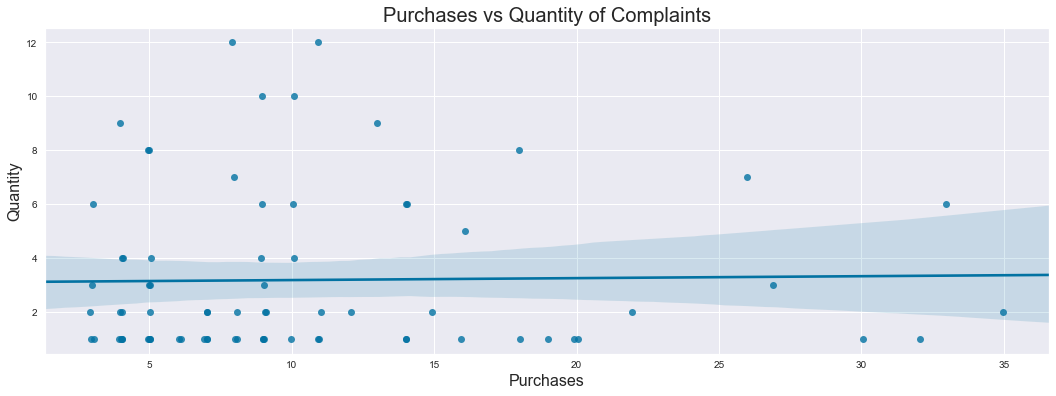

In [15]:
# Group and sum compliants by DoctorID
complaints_group = complaints.groupby('DoctorID').sum().reset_index()
# Merge complaints table to doctors table
purchases_and_complaints = complaints_group.merge(doctors[["DoctorID", "Purchases"]], on="DoctorID").fillna(0)
# Remove outliers
remove_outliers(purchases_and_complaints)

display(purchases_and_complaints.head())
print(f"No. of instances where quantity of complaints were more than number of purchases {np.sum(purchases_and_complaints['Qty'] > purchases_and_complaints['Purchases'])}")

# Print correlation between Purchases and Qty of complaints
print(f"Correlation between purchases and quantity of complaints: {purchases_and_complaints['Qty'].corr(purchases_and_complaints['Purchases'])}")
# Plot Purchases vs Qty of complaints
plt.figure(figsize=(18,6))
sns.regplot(y='Qty', x='Purchases', data=purchases_and_complaints, truncate=False, x_jitter=.1)
plt.xlabel("Purchases", fontsize=16)
plt.ylabel("Quantity", fontsize=16)
plt.title("Purchases vs Quantity of Complaints", fontsize=20)
plt.show()

Pearson’s Correlation coefficient is a measure for the strength of a linear relationship between two variables. A coefficient between 0.3 and 0.5 is generally considered as weak, meaning that the two variables show no strong linear relationship. A coefficient between 0.5 and 0.7 is considered as moderate, whereas a correlation between 0.7 and 0.9 is considered strong. The correlation number and regression plot shows the no relationship between number of purchases and quantity of complaints.

There are also instances where quantity of complaints is greater than number of purchases. This could possibly be due to 1. Data Error 2. Multiple complaints regarding to same purchase 3. Complaints to purchases over a year ago since `Purchases` only contains data about purchases over the last year.

## 4 Exploratory Data Analysis (EDA)

Let's start by merging the four dataframes together. Next we will explore each column in the merged dataframe to better understand their type, distribution or frequency, and possible methods of addressing missing information.

**Summary**:
- `DoctorID`, `OrderID`, `OrderNum` are IDs and will be dropped in modeling.
- Fill missing categorical variables with "Missing" or drop rows
- Fill missing numerical variables with 0, impute with mean/median, or drop rows
- Encode categorical variables

In [16]:
# list of dataframes to merge
data_frames = [doctors, orders, complaints, instructions]

df_merged = reduce(lambda left,right: pd.merge(left,right, how="outer", on=['DoctorID']), data_frames)

dqr(df_merged)

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases,OrderID,...,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J,Complaint Type,Qty,Instructions
0,AHDCBA,4 15,Specialist,Ambassador,49.0,0.90,53.85,1.20,49.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1,ABHAHF,1 8 T4,General Practitioner,Ambassador,37.0,0.00,100.00,0.00,38.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FDHFJ,1 9 T4,Specialist,Ambassador,33.0,1.53,--,0.00,34.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BJJHCA,1 10 T3,Specialist,Ambassador,28.0,2.03,--,0.48,29.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FJBEA,1 14 T4,Specialist,Ambassador,23.0,0.96,76.79,0.75,24.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,count,mean,std,min,25%,50%,75%,max
Incidence rate,786.0,4.8,3.5,2.0,3.0,4.0,5.6,49.0
R rate,786.0,1.2,0.8,0.0,0.8,1.0,1.5,4.2
Experience,786.0,0.6,0.5,0.0,0.2,0.6,0.8,5.4
Purchases,786.0,13.8,15.3,3.0,4.0,8.0,16.0,129.0
Qty,742.0,1.8,1.6,1.0,1.0,1.0,2.0,15.0


,Data Type,Records,Unique Values,Missing Values,Missing %
DoctorID,object,1105,647,0,0.00
Region,object,786,46,319,28.87
Category,object,786,2,319,28.87
Rank,object,784,9,321,29.05
Incidence rate,float64,786,63,319,28.87
R rate,float64,786,137,319,28.87
Satisfaction,object,786,99,319,28.87
Experience,float64,786,106,319,28.87
Purchases,float64,786,45,319,28.87
OrderID,object,434,249,671,60.72


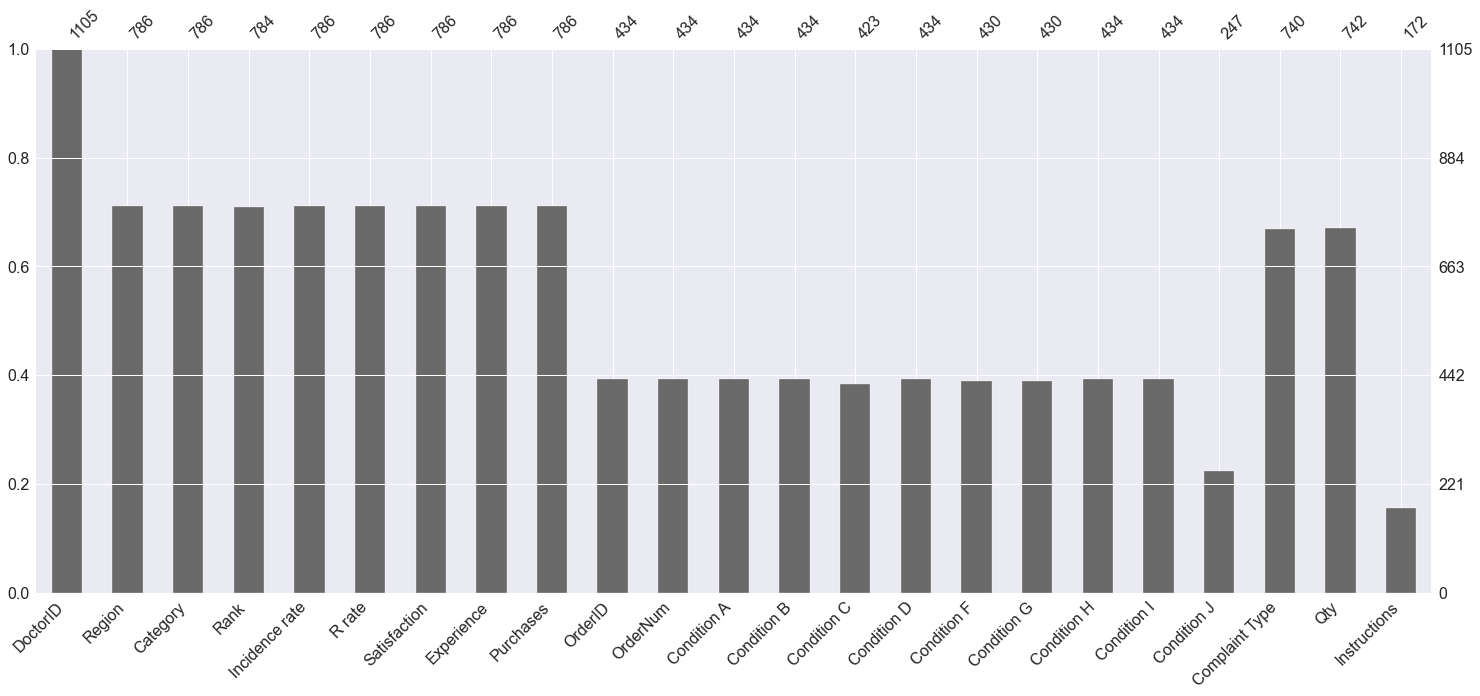

In [17]:
msno.bar(df_merged)
plt.show()

The y-axis scale ranges from 0.0 to 1.0, where 1.0 represents 100% data completeness. If the bar is less than this, it indicates that we have missing values within that column. `DoctorID` has 100% completeness while `Instructions` have the most number of missing values. This is expected because we used an outer join to merge the dataframes together.

### 4.1 Region

- Categorical variable
- Convert missing values to "Missing" variable or drop those rows
- Since each row represents a Doctor review 3.1 for mode and countplot of region.

In [18]:
display(df_merged["Region"].head())

0       4 15
1     1 8 T4
2     1 9 T4
3    1 10 T3
4    1 14 T4
Name: Region, dtype: object

### 4.2 Category

- Categorical variable, two categories: Specialist, or General Practitioner
- Convert missing values to "Missing" variable or drop those rows
- Most doctors are Specialists (707), only 79 doctors are General Practitioners

0              Specialist
1    General Practitioner
2              Specialist
3              Specialist
4              Specialist
Name: Category, dtype: object

array(['Specialist', 'General Practitioner', nan], dtype=object)

Specialist              707
General Practitioner     79
Name: Category, dtype: int64

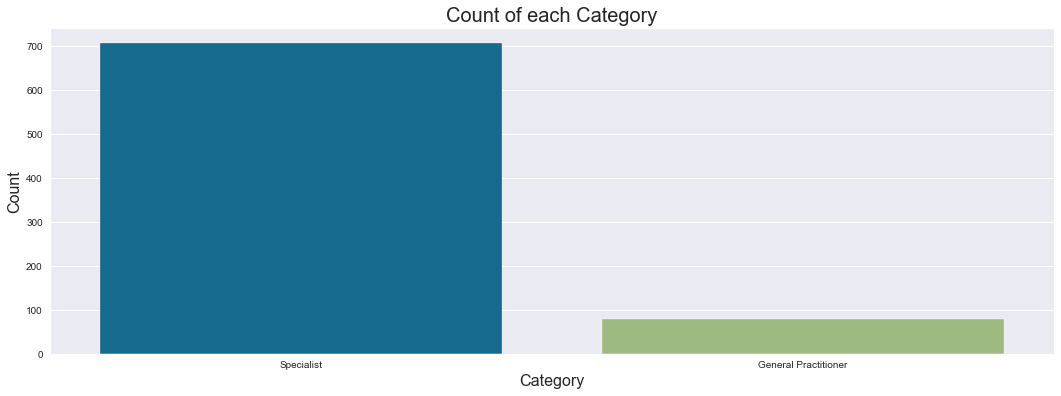

In [19]:
display(df_merged["Category"].head())
print("\n")
display(df_merged["Category"].unique())
print("\n")
display(df_merged["Category"].value_counts())

# Plot countplot of Category
plt.figure(figsize=(18,6))
sns.countplot(x="Category", data=df_merged)
plt.xlabel("Category", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Count of each Category", fontsize=20)
plt.show()

### 4.3 Rank

- Ordered Categorical variable, there are nine categories. 
- The highest rank is Ambassadors, followed by Titanium Plus, Titanium, Platinum Plus, Platinum, Gold Plus, Gold, Silver Plus, and the lowest level is Silver.
- Data imbalance, only 1 Doctor is Rank Titanium Plus
- Most common rank is Ambassador, least common Titanium Plus
- Use ordinal encoding, where missing will be -1. However, this assumes that the numerical distance between each set of subsequent rank is equal.

0    Ambassador
1    Ambassador
2    Ambassador
3    Ambassador
4    Ambassador
Name: Rank, dtype: object

array(['Ambassador', 'Platinum Plus', 'Titanium', 'Silver Plus', 'Gold',
       'Platinum', 'Gold Plus', 'Silver', nan, 'Titanium Plus'],
      dtype=object)

Ambassador       277
Platinum         146
Titanium         128
Gold Plus         79
Platinum Plus     73
Silver Plus       50
Gold              27
Silver             3
Titanium Plus      1
Name: Rank, dtype: int64

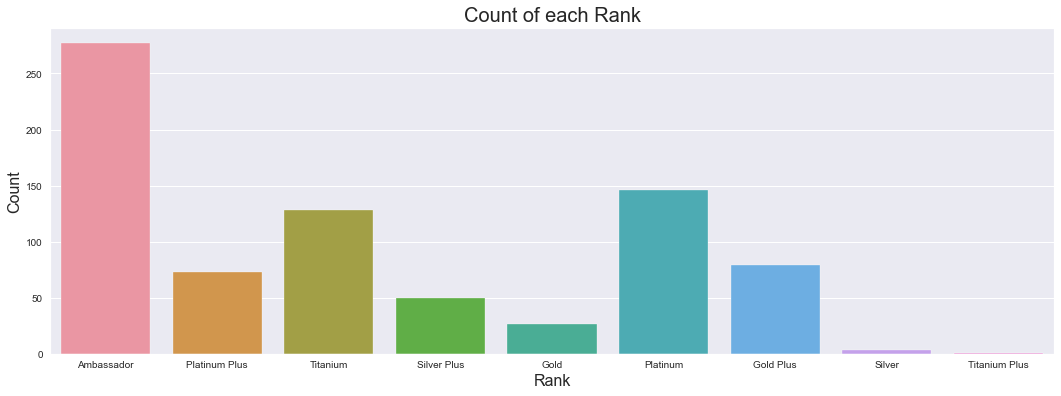

In [20]:
display(df_merged["Rank"].head())
print("\n")
display(df_merged["Rank"].unique())
print("\n")
display(df_merged["Rank"].value_counts())

# Plot countplot of Rank
plt.figure(figsize=(18,6))
sns.countplot(x="Rank", data=df_merged)
plt.xlabel("Rank", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Count of each Rank", fontsize=20)
plt.show()

###  4.4 Incidence rate

- Numerical variable
- Impute missing values with 0 or drop rows
- Right skewed distribution ranging from 2 to 29 with a median of 4.
- Apply log transformer to handle skewness
- Possible outliers as seen in the boxplot, however will be kept because there is no indication this is incorrectly entered or measured data,

0    49.0
1    37.0
2    33.0
3    28.0
4    23.0
Name: Incidence rate, dtype: float64

Meidan: 4.0
Skew: 5.607171363436355


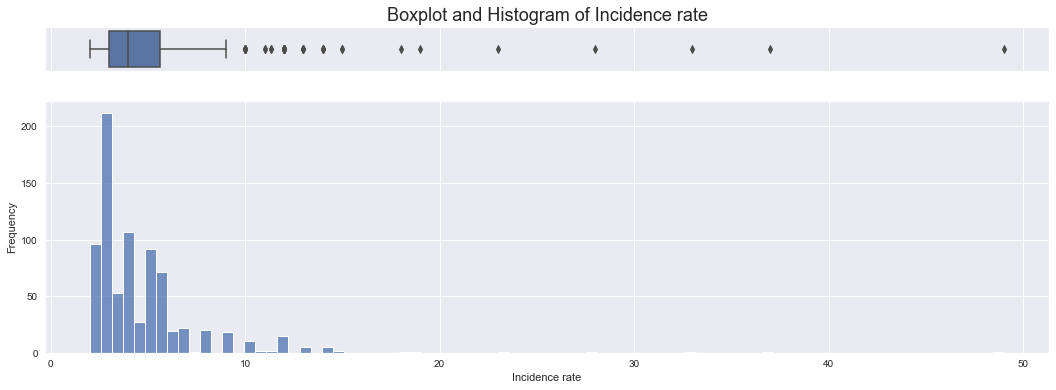

In [21]:
display(df_merged["Incidence rate"].head())
print(f'Meidan: {df_merged["Incidence rate"].quantile(0.5)}')
print(f'Skew: {df_merged["Incidence rate"].skew()}')

# Creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(18,6))
sns.set(font_scale = 1.5)

# Assigning a graph to each ax
sns.boxplot(x="Incidence rate", data=df_merged, ax=ax_box)
sns.histplot(x="Incidence rate", data=df_merged, ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='', title="Boxplot and Histogram of Incidence rate")
ax_hist.set(xlabel="Incidence rate", ylabel="Frequency")
plt.show()

Skew of default: 5.607171363436355
Skew of log transform: 1.2241053607140613
Skew of square-root transform: 2.619246516085647
Skew of cube-root transform: 2.025533508846419


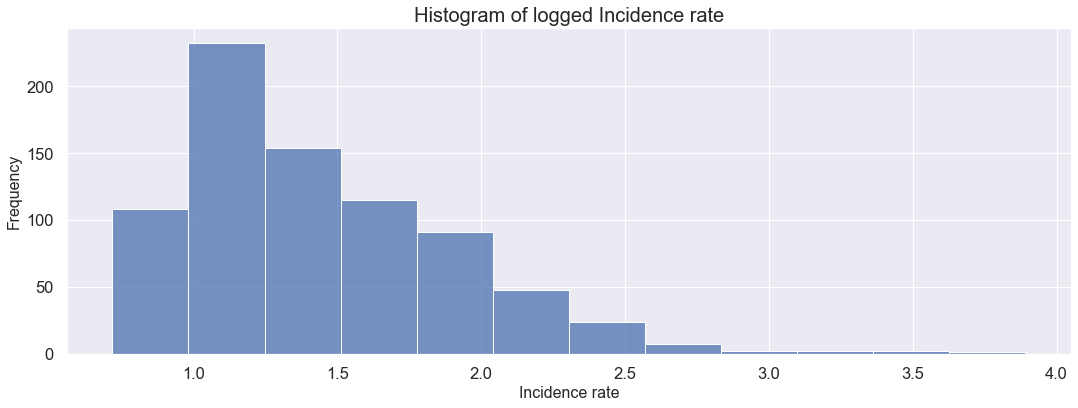

In [22]:
print(f'Skew of default: {df_merged["Incidence rate"].skew()}')
print(f'Skew of log transform: {np.log(df_merged["Incidence rate"]).skew()}')
print(f'Skew of square-root transform: {np.sqrt(df_merged["Incidence rate"]).skew()}')
print(f'Skew of cube-root transform: {np.cbrt(df_merged["Incidence rate"]).skew()}')

# Plot histogram of logged Incidence rate
plt.figure(figsize=(18,6))
sns.histplot(np.log(df_merged["Incidence rate"]), bins=12)
plt.xlabel("Incidence rate", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Histogram of logged Incidence rate", fontsize=20)
plt.show()

###  4.5 R rate

- Numerical variable
- Only positive values
- Impute missing values with 0 or drop rows
- Right skewed distribution ranging from 0 to 4.2 with a median of 1.
- Possible outliers as seen in the boxplot, however will be kept because there is no indication this is incorrectly entered or measured data,

0    0.90
1    0.00
2    1.53
3    2.03
4    0.96
Name: R rate, dtype: float64

Meidan: 1.0
Skew: 1.8086653960068204


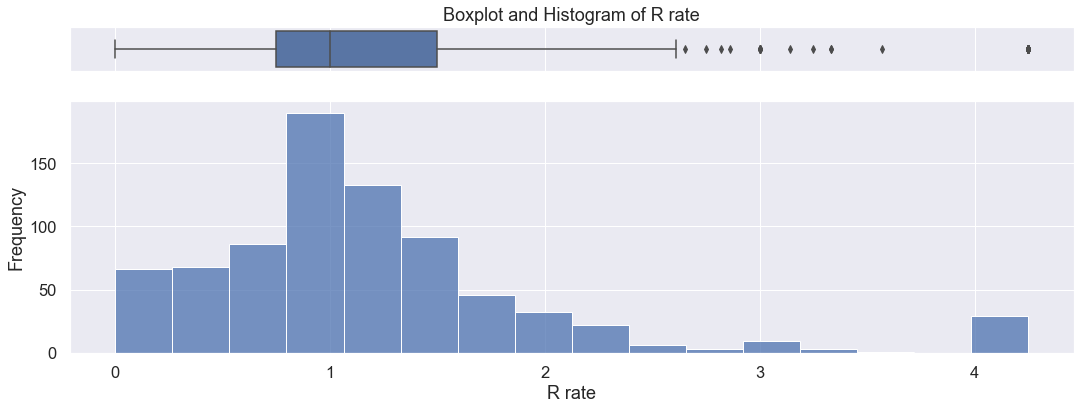

In [23]:
display(df_merged["R rate"].head())
print(f'Meidan: {df_merged["R rate"].quantile(0.5)}')
print(f'Skew: {df_merged["R rate"].skew()}')

# Creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(18,6))
sns.set(font_scale = 1.5)

# Assigning a graph to each ax
sns.boxplot(x="R rate", data=df_merged, ax=ax_box)
sns.histplot(x="R rate", data=df_merged, ax=ax_hist, bins=16)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='', title="Boxplot and Histogram of R rate")
ax_hist.set(xlabel="R rate", ylabel="Frequency")
plt.show()

### 4.6 Satisfaction

- Numerical variable, spanning from -100 to 100
- Contains some -- characters, fill missing values with 0 or drop rows
- When removing the "--" characters from the column, we see a left skewed distribution of the doctor's satisfaction with the company. 
- The relation between mean, median, and mode is Mean < Median < Mode.

No. of dashes in Satisfaction: 187
Skew: -0.662765167744903


count    250.000000
mean      29.218720
std       61.225893
min     -100.000000
25%      -12.315000
50%       39.230000
75%       83.330000
max      100.000000
Name: Satisfaction, dtype: float64

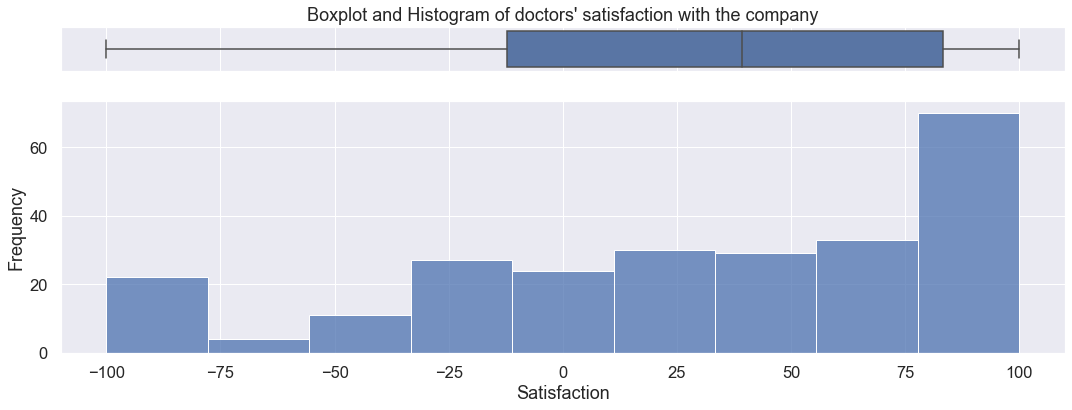

In [24]:
# Filter rows in Satisfaction that match --
dashes = doctors["Satisfaction"] == "--"
print(f"No. of dashes in Satisfaction: {sum(dashes)}")

# Remove dashes
satisfaction = doctors[~dashes]["Satisfaction"].astype(float)
satisfaction_med = satisfaction.quantile(0.5)
print(f'Skew: {pd.Series(satisfaction).skew()}')
display(satisfaction.describe())

# Creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(18,6))
sns.set(font_scale = 1.5)

# Assigning a graph to each ax
sns.boxplot(satisfaction, ax=ax_box)
sns.histplot(satisfaction, ax=ax_hist)

# Remove x axis name for the boxplot
ax_box.set(xlabel='', title="Boxplot and Histogram of doctors' satisfaction with the company")
ax_hist.set(xlabel="Satisfaction", ylabel="Frequency")
plt.show()

### 4.7 Experience

- Numerical variable
- Only positive values as expected
- Fill missing value with 0 or drop rows
- Right skewed distribution ranging from 0 to 5.4, with a median of 0.57.
- Possible outliers as seen in the boxplot, however will be kept because there is no indication this is incorrectly entered or measured data,

0    1.20
1    0.00
2    0.00
3    0.48
4    0.75
Name: Experience, dtype: float64

Meidan: 0.57
Skew: 2.711810861459008


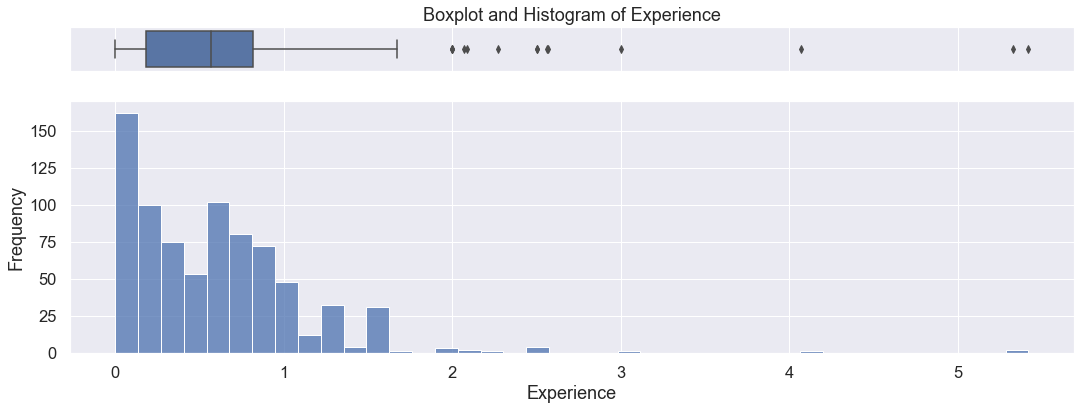

In [25]:
display(df_merged["Experience"].head())
print(f'Meidan: {df_merged["Experience"].quantile(0.5)}')
print(f'Skew: {df_merged["Experience"].skew()}')

# Creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(18,6))
sns.set(font_scale = 1.5)

# Assigning a graph to each ax
sns.boxplot(x="Experience", data=df_merged, ax=ax_box)
sns.histplot(x="Experience", data=df_merged, ax=ax_hist)

# Remove x axis name for the boxplot
ax_box.set(xlabel='', title="Boxplot and Histogram of Experience")
ax_hist.set(xlabel="Experience", ylabel="Frequency")
plt.show()

### 4.8 Purchases

- Discrete Numerical variable
- Only positive values as expected
- Fill missing value with 0 or drop rows
- Right skewed distribution ranging from 3 to 129 with a median of 8.
- Possible outliers as seen in the boxplot, however will be kept because there is no indication this is incorrectly entered or measured data,

0    49.0
1    38.0
2    34.0
3    29.0
4    24.0
Name: Purchases, dtype: float64

Meidan: 8.0
Skew: 2.8726322076942634


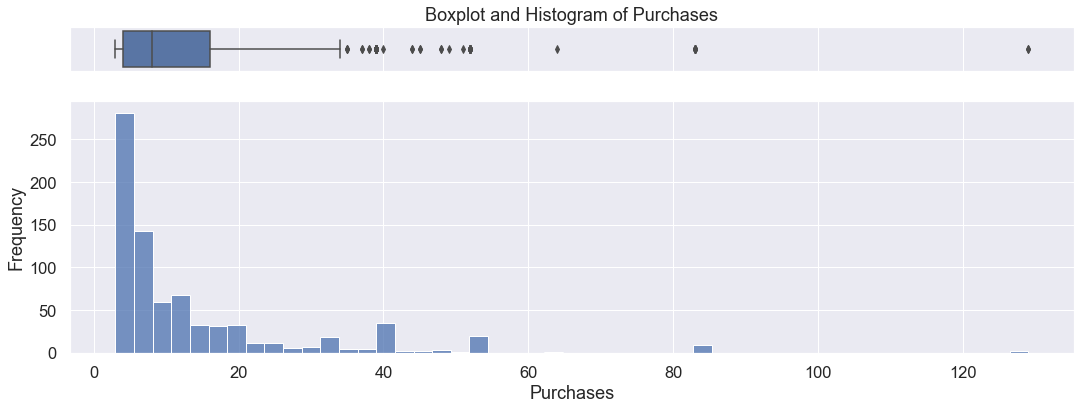

In [26]:
display(df_merged["Purchases"].head())
print(f'Meidan: {df_merged["Purchases"].quantile(0.5)}')
print(f'Skew: {df_merged["Purchases"].skew()}')

# Creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(18,6))
sns.set(font_scale = 1.5)

# Assigning a graph to each ax
sns.boxplot(x="Purchases", data=df_merged, ax=ax_box)
sns.histplot(x="Purchases", data=df_merged, ax=ax_hist)

# Remove x axis name for the boxplot
ax_box.set(xlabel='', title="Boxplot and Histogram of Purchases")
ax_hist.set(xlabel="Purchases", ylabel="Frequency")
plt.show()

### 4.9 Condition A-J

- No Condition E
- Boolean variable
- Condition A-H are True, False
- Condition J are Before, After
- Fill missing variables with mode, or drop rows
- Encode to 0 and 1

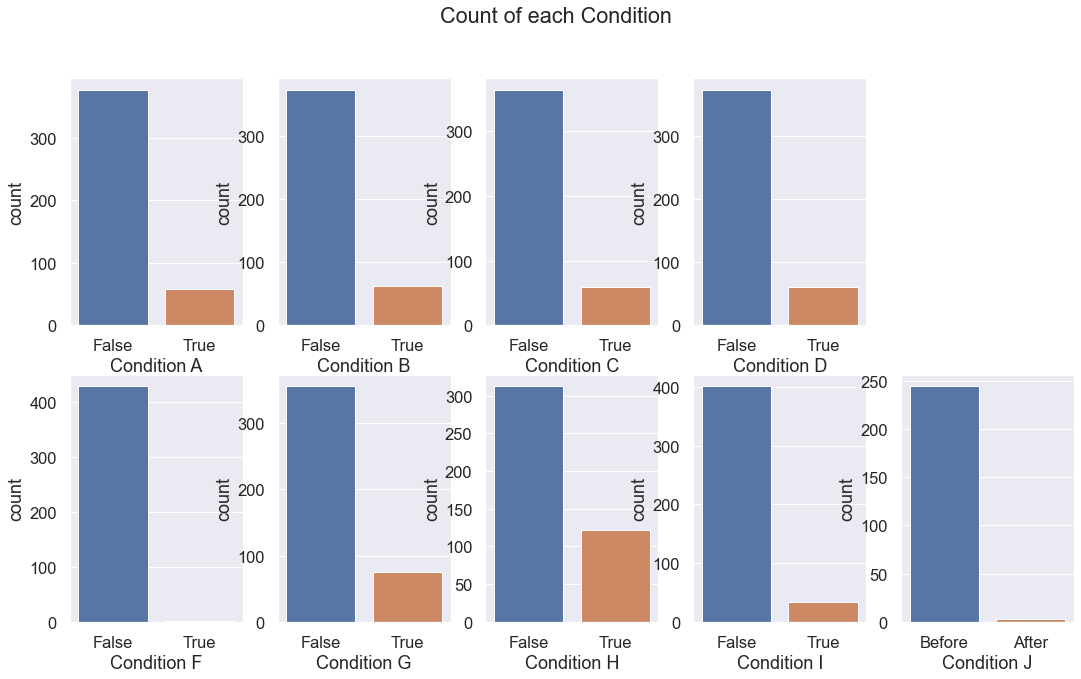

In [27]:
# Plot subplots of Condition A-J
fig, axs = plt.subplots(2, 5, figsize=(18,10))
fig.suptitle('Count of each Condition')
sns.countplot(x="Condition A", data=df_merged, ax=axs[0, 0])
sns.countplot(x="Condition B", data=df_merged, ax=axs[0, 1])
sns.countplot(x="Condition C", data=df_merged, ax=axs[0, 2])
sns.countplot(x="Condition D", data=df_merged, ax=axs[0, 3])
axs[0, 4].axis('off')
sns.countplot(x="Condition F", data=df_merged, ax=axs[1, 0])
sns.countplot(x="Condition G", data=df_merged, ax=axs[1, 1])
sns.countplot(x="Condition H", data=df_merged, ax=axs[1, 2])
sns.countplot(x="Condition I", data=df_merged, ax=axs[1, 3])
sns.countplot(x="Condition J", data=df_merged, ax=axs[1, 4])
plt.show()

### 4.10 Complaint Type

- Categorical variable
- Most common complaint type is "Correct"
- Convert missing values to "Missing" variable or drop those rows

Correct      355
Incorrect    220
Unknown      152
Specific      11
R&R            2
Name: Complaint Type, dtype: int64

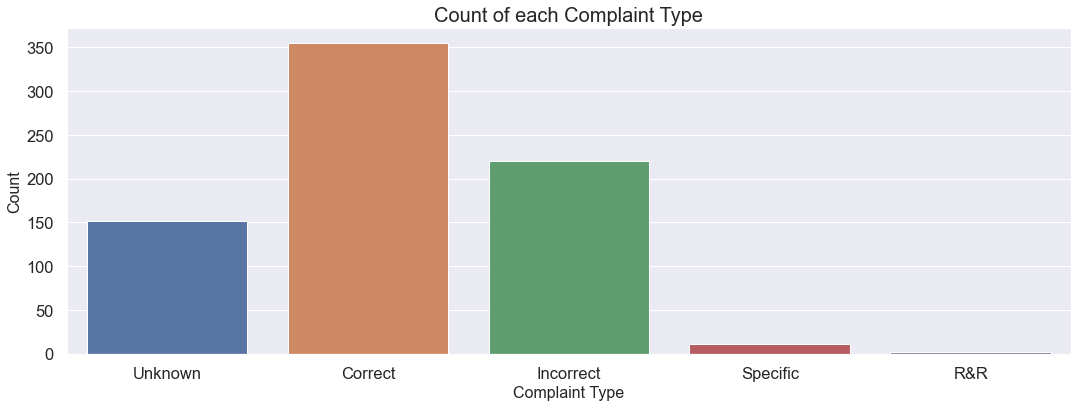

In [28]:
display(df_merged["Complaint Type"].value_counts())

# Plot countplot of Complaint Type
plt.figure(figsize=(18,6))
sns.countplot(x="Complaint Type", data=df_merged)
plt.xlabel("Complaint Type", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Count of each Complaint Type", fontsize=20)
plt.show()

### 4.11 Qty

- Discrete numerical variable
- Right skewed distribution, ranging from 1 to 15.
- Fill missing with 0 or drop rows
- Possible outliers as seen in the boxplot, however will be kept because there is no indication this is incorrectly entered or measured data,

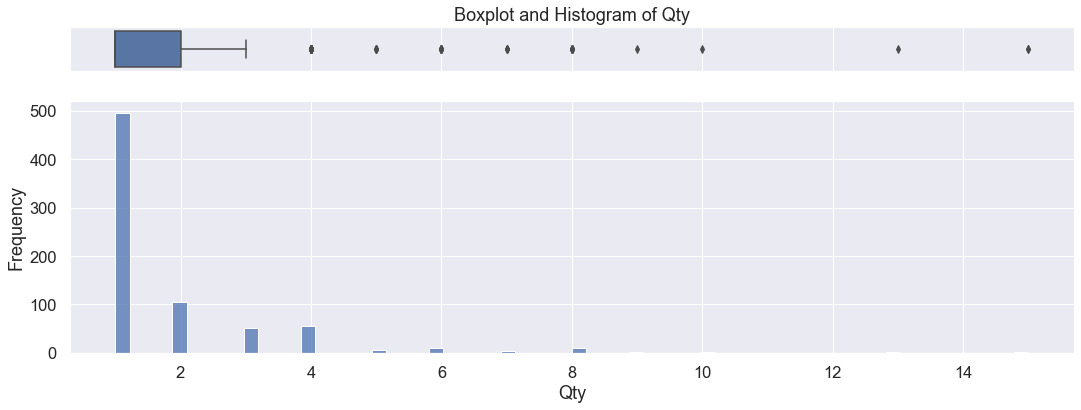

In [29]:
# Creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(18,6))
sns.set(font_scale = 1.5)

# Assigning a graph to each ax
sns.boxplot(x="Qty", data=df_merged, ax=ax_box)
sns.histplot(x="Qty", data=df_merged, ax=ax_hist)

# Remove x axis name for the boxplot
ax_box.set(xlabel='', title="Boxplot and Histogram of Qty")
ax_hist.set(xlabel="Qty", ylabel="Frequency")
plt.show()

### 4.12 Instructions

- Binary variable
- Fill missing with "No"
- Encode to 0, 1

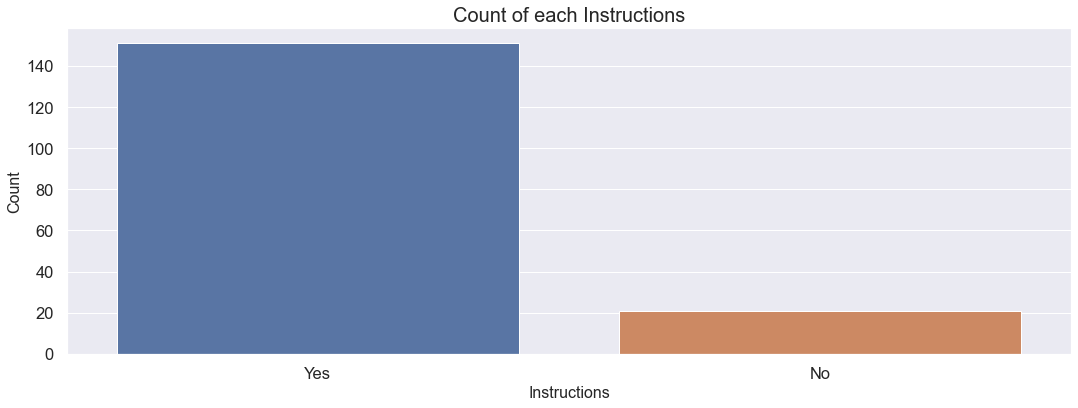

In [30]:
# Plot countplot of Instructions
plt.figure(figsize=(18,6))
sns.countplot(x="Instructions", data=df_merged)
plt.xlabel("Instructions", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Count of each Instructions", fontsize=20)
plt.show()

## 5 Feature Selection and Engineering

Based on our EDA, we recognize the dataset contains a mixture of identifier, categorical and continuous data, as well as missing values. We will now perform data preprocessing. 

In [31]:
# List of numerical columns
num_cols = ['Incidence rate', 'R rate', 'Satisfaction', 'Experience', 'Purchases', 'Qty']
# List of categorical columns that could be one hot encoded
cat_cols = ["Region", "Category", "Complaint Type"]

### 5.1 Dropping identifiers, filling missing values, and encoding
- Drop ID columns
- Fill in missing values
- One hot encoding categorical variables
- Ordinal encoding on Rank
- Label Encoding on binary variables
- Change type of column as approriate

In [32]:
# Create function to perform preprocessing on dataframe
def preproc(df):
    """
    Perform preprocessing (drop columns, fill missing values, encode columns) on dataframe
    
    ARGS:
    df (dataframe): Pandas dataframe
    
    OUTPUT:
    Preprocessed dataframe
    """
    # Drop ID columns
    df.drop(["DoctorID", "OrderID", "OrderNum"], axis=1, inplace=True)
    # Fill missing Region values
    df["Region"].fillna("Missing", inplace=True)
    df["Region"] = df["Region"].astype("category")
    # Fill missing Category values
    df["Category"].fillna("Missing", inplace=True)
    # Ordinal Encode Rank values, fill missing with -1
    df["Rank"] = df["Rank"].map({'Silver': 0, 
                 'Silver Plus': 1, 
                 'Gold': 2, 
                 'Gold Plus': 3, 
                 'Platinum': 4, 
                 'Platinum Plus': 5, 
                 'Titanium': 6, 
                 'Titanium Plus': 7, 
                 'Ambassador': 8})
    df["Rank"].fillna(-1, inplace=True)
    # Fill missing Incidence rate values
    df["Incidence rate"] = df["Incidence rate"].fillna(0).astype(float)
    # Fill missing R rate values
    df["R rate"] = df["R rate"].fillna(0).astype(float)
    # Replace -- rows, and fill missing Satifactions values with 0
    df["Satisfaction"] = df["Satisfaction"].replace("--", 0)
    df["Satisfaction"] = df["Satisfaction"].fillna("0").astype(float)
    # Fill missing Experience values
    df["Experience"] = df["Experience"].fillna(0).astype(float)
    # Fill missing Purchases values
    df["Purchases"] = df["Purchases"].fillna(0).astype(float)    
    # Encode boolean columns
    enc = Pipeline(steps=[
        ("encoder", OrdinalEncoder()),
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ])
    df[["Condition A", 
        "Condition B", 
        "Condition C", 
        "Condition D", 
        "Condition F", 
        "Condition G", 
        "Condition H", 
        "Condition I"]] = enc.fit_transform(df[["Condition A", 
                                                      "Condition B", 
                                                      "Condition C", 
                                                      "Condition D", 
                                                      "Condition F", 
                                                      "Condition G", 
                                                      "Condition H",
                                                      "Condition I"]])
    # Encode Condition J, fill mising with -1
    df["Condition J"] = df["Condition J"].map({"Before": 0, 
                                               "After": 1
                                              })
    df["Condition J"].fillna(-1, inplace=True)
    # Fill missing Complaint Type values
    df["Complaint Type"].fillna("Missing", inplace=True)
    # Fill missing Qty values
    df["Qty"] = df["Qty"].fillna(0).astype(float)
    # Encode Instructions, fill mising with 0
    df["Instructions"] = df["Instructions"].map({"No": 0, 
                                               "Yes": 1
                                              })
    df["Instructions"].fillna(0, inplace=True)
    # One hot encoding on categorical columns
    df = pd.get_dummies(df, columns=cat_cols)
    return df

In [33]:
processed_df = df_merged.copy()
processed_df = preproc(processed_df)
display(processed_df.columns)
print(f"Number of features: {len(processed_df.columns)}")
processed_df.head()

Index(['Rank', 'Incidence rate', 'R rate', 'Satisfaction', 'Experience',
       'Purchases', 'Condition A', 'Condition B', 'Condition C', 'Condition D',
       'Condition F', 'Condition G', 'Condition H', 'Condition I',
       'Condition J', 'Qty', 'Instructions', 'Region_1 10', 'Region_1 10 T3',
       'Region_1 11', 'Region_1 12', 'Region_1 12 T3', 'Region_1 12 T4',
       'Region_1 13', 'Region_1 13 T3', 'Region_1 13 T4', 'Region_1 14',
       'Region_1 14 T3', 'Region_1 14 T4', 'Region_1 19', 'Region_1 19 20',
       'Region_1 19 T3', 'Region_1 19 T4', 'Region_1 21 T3', 'Region_1 21 T4',
       'Region_1 4CP', 'Region_1 8', 'Region_1 8 T3', 'Region_1 8 T4',
       'Region_1 9', 'Region_1 9 T3', 'Region_1 9 T4', 'Region_17',
       'Region_2 11', 'Region_2 6 10', 'Region_2 6 12', 'Region_2 6 13',
       'Region_2 6 14', 'Region_2 6 19', 'Region_2 6 8', 'Region_2 6 9',
       'Region_2 7 10', 'Region_2 7 12', 'Region_2 7 13', 'Region_2 7 14',
       'Region_2 7 19', 'Region_2 7 8', '

Number of features: 73


,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases,Condition A,Condition B,Condition C,Condition D,...,Region_Missing,Category_General Practitioner,Category_Missing,Category_Specialist,Complaint Type_Correct,Complaint Type_Incorrect,Complaint Type_Missing,Complaint Type_R&R,Complaint Type_Specific,Complaint Type_Unknown
0,8.0,49.0,0.90,53.85,1.20,49.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,1,0,0,0
1,8.0,37.0,0.00,100.00,0.00,38.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,0,0,0
2,8.0,33.0,1.53,0.00,0.00,34.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,1,0,0,0
3,8.0,28.0,2.03,0.00,0.48,29.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,1,0,0,0
4,8.0,23.0,0.96,76.79,0.75,24.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,1,0,0,0


### 5.2 Feature Scaling

Using [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to make sure features with different scales don't introduce bias into clustering

In [34]:
# Scale numerical features
scaler = MinMaxScaler()
scaled_df = processed_df.copy()
scaled_df[num_cols] = pd.DataFrame(MinMaxScaler().fit_transform(scaled_df[num_cols]), 
                               index=scaled_df.index)

### 5.3 Principal Component Analysis (PCA)

This method is used to reduce the dimensionality of the dataset. Let have set up a loop function to identify number of principal components that explain at least 85% of the variance in the dataset.

In [35]:
RANDOM_STATE = 23

# Loop Function to identify number of principal components that explain at least 85% of the variance
for comp in range(2, scaled_df.shape[1]):
    pca = PCA(n_components=comp, random_state=RANDOM_STATE)
    pca.fit(scaled_df)
    comp_check = pca.explained_variance_ratio_
    n_comp = comp
    if comp_check.sum() > 0.85:
        break
        
pca = PCA(n_components=n_comp, random_state=RANDOM_STATE)
pca_df = pd.DataFrame(pca.fit_transform(scaled_df), index=scaled_df.index)
num_comps = comp_check.shape[0]
print("Using {} components, we can explain {}% of the variability in the original data.".format(n_comp, comp_check.sum()*100))
pca_df.head()

Using 2 components, we can explain 87.06746784108557% of the variability in the original data.


,0,1
0,-4.474670,-0.669163
1,-4.334824,-0.723871
2,-4.443076,-0.706745
3,-4.443955,-0.714453
4,-4.441273,-0.707036


## 6 Define new doctor segments
Our objective is to help the company improve their marketing efforts and customer service by creating new doctor segments from an unlabeled dataset, hence an unsupervised machine learning and clustering appears to be the most reasonable choice of the model. Clustering divides a set of objects or observations (in this case doctors) into different groups based on their features or properties. The division is done in such that the observations are as similar as possible to each other within the same cluster. In addition, each cluster should be as far away from the others as possible.

### 6.1 Optimal number of clusters

We will use the elbow method to determe the optimal number of clusters. The method calculates the Within-Cluster-Sum of Squared Errors (WSS) for different number of clusters (k) and selecting the k for which change in WSS first starts to diminish.
- Based on the distortion score at different k, 5 is the optimal number of clusters.

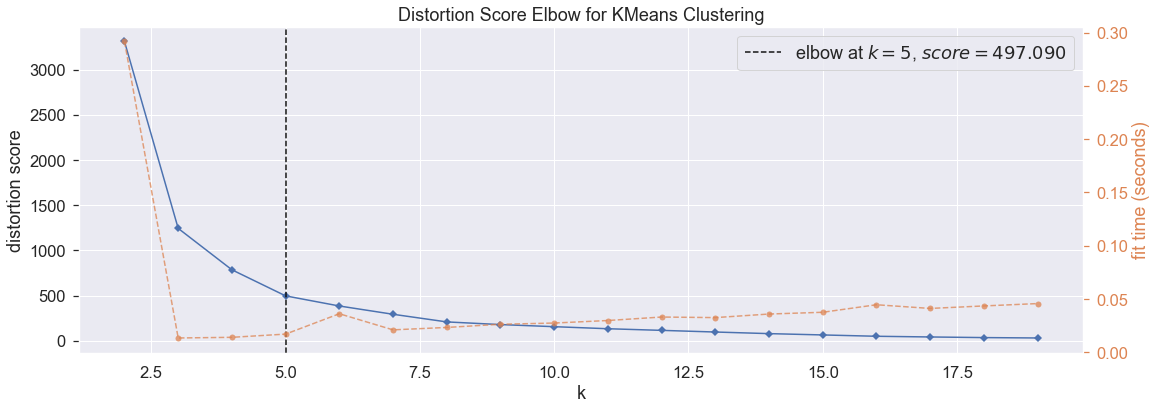

In [36]:
# Elbow method using yellowbrick library
plt.figure(figsize=(18,6))
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20), timings= True)
visualizer.fit(pca_df)
visualizer.show()
plt.show()

### 6.2 KMeans clustering

KMeans is an iterative algorithm that partitions the dataset into K pre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to only one group.

The graph shows the scatter plot of the data colored by the cluster they belong to based on their similarity.

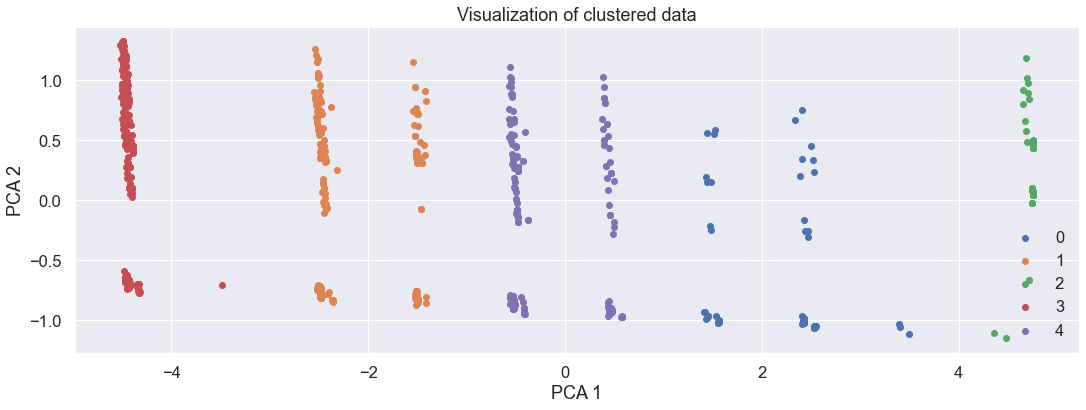

In [37]:
k = 5
km = KMeans(n_clusters=k, random_state=RANDOM_STATE).fit(pca_df)
label = km.labels_

# Getting unique labels
u_labels = np.unique(label)

plt.figure(figsize=(18,6))
for i in u_labels:
    plt.scatter(pca_df.iloc[label == i, 0] , pca_df.iloc[label == i, 1] , label = i)
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Visualization of clustered data")
plt.show()

### 6.3 Which features impact the new segmentation strategy the most

Now that we have identified our clusters, let's extract each cluster’s most important features. One approach is to convert the unsupervised clustering problem into a One-vs-All supervised classification problem.

1. Change the cluster labels into One-vs-All binary labels
2. Train a classifier to discriminate between each cluster and all other clusters
3. Extract the feature importances from the model (We will be using sklearn.ensemble.RandomForestClassifier)

From the weights we identify `Rank` as the most important feature, this is usually followed by purchases and R rate.

In [38]:
scaled_df["Cluster"] = label
scaled_df['Binary Cluster 0'] = scaled_df['Cluster'].map({0:1, 1:0, 2:0, 3:0, 4:0})
scaled_df['Binary Cluster 1'] = scaled_df['Cluster'].map({0:0, 1:1, 2:0, 3:0, 4:0})
scaled_df['Binary Cluster 2'] = scaled_df['Cluster'].map({0:0, 1:0, 2:1, 3:0, 4:0})
scaled_df['Binary Cluster 3'] = scaled_df['Cluster'].map({0:0, 1:0, 2:0, 3:1, 4:0})
scaled_df['Binary Cluster 4'] = scaled_df['Cluster'].map({0:0, 1:0, 2:0, 3:0, 4:1})

# Train a classifier
from sklearn.ensemble import RandomForestClassifier
scaled_df_train = scaled_df.drop(["Cluster", "Binary Cluster 0", "Binary Cluster 1", "Binary Cluster 2", "Binary Cluster 3", "Binary Cluster 4"], axis=1)

for i in range(5):
    clf = RandomForestClassifier(random_state=RANDOM_STATE)
    clf.fit(scaled_df_train.values, scaled_df["Binary Cluster " + str(i)].values)
    # Index sort the most important features
    sorted_feature_weight_idxes = np.argsort(clf.feature_importances_)[::-1] # Reverse sort
    # Get the most important features names and weights
    most_important_features = np.take_along_axis(np.array(scaled_df_train.columns.tolist()), sorted_feature_weight_idxes, axis=0)
    most_important_weights = np.take_along_axis(np.array(clf.feature_importances_), sorted_feature_weight_idxes, axis=0)
    # Show
    print(list(zip(most_important_features, most_important_weights))[:3])

[('Rank', 0.3462422263806552), ('R rate', 0.060365456749001456), ('Category_General Practitioner', 0.05741863343778913)]
[('Rank', 0.36374424881372586), ('Purchases', 0.08363203178543055), ('Region_1 8 T3', 0.06992636245787862)]
[('Rank', 0.16906243640382515), ('Category_Missing', 0.16547351972134908), ('Purchases', 0.16081255501034938)]
[('Rank', 0.44233890242367024), ('Purchases', 0.16679337117408138), ('R rate', 0.06584395381200006)]
[('Rank', 0.3689971859520564), ('Purchases', 0.10372479238158124), ('R rate', 0.09107045419109543)]


## 7 Characteristics that distinguish the newly defined segments

Now that we have identified new doctor segments, let's identify their characteristics. 

Each cluster contains the following groups of `Ranks`:
- Silver, Silver Plus, Gold
- Gold Plus, "Platinum
- Platinum Plus, Titanium
- Titanium Plus, Ambassador
- Missing

Let's also explore whether other columns have any relationships with feature `Rank`. By calculating the pairwise correlation, we see that it suggests a strong positive relationship with `Purchases`, and a moderate positive relationship with `Incidence rate`, `R rate`. We can dismiss `Category_Specialist`, because as seen in 4.2, most doctors are categorized as specialists.

In [39]:
cluster_df = scaled_df.copy()

# Groupby cluster
display(cluster_df.groupby("Cluster")["Rank"].value_counts())
# Rank's correlation with other columns
rank_corr = scaled_df_train.corrwith(scaled_df['Rank']).reset_index().sort_values(0, ascending=False).rename({"index": "Column", 0: "Correlation"}, axis=1)
display(rank_corr.head(5))

Cluster  Rank
0         1.0     50
          2.0     27
          0.0      3
1         6.0    128
          5.0     73
2        -1.0    321
3         8.0    277
          7.0      1
4         4.0    146
          3.0     79
Name: Rank, dtype: int64

,Column,Correlation
0,Rank,1.000000
66,Category_Specialist,0.797082
5,Purchases,0.631280
1,Incidence rate,0.526836
2,R rate,0.441926


### 7.1 Rank vs Purchases

From the violin plot, we can see there is a positive relationship between Rank and Purchases, where the higher Ranks have a higher number of purchases. This is also seen in the median number of purchases of each rank,  with the exception of Silver Rank. Therefore, Rank is helpful indicator in predicting the number of purchases a doctor will make. Ambassador Rank has the highest number of purchases, with a high of 129 purchases. Titanium Plus looks like an outlier on the violin plot, but this can be attributed to having a small sample size of doctors in that rank.

Median number of Purchases by Rank


Rank
Silver            7.0
Silver Plus       4.0
Gold              3.0
Platinum          5.0
Platinum Plus     7.0
Titanium         10.0
Titanium Plus    14.0
Ambassador       20.0
Name: Purchases, dtype: float64

Max number of Purchases by Rank


Rank
Silver             8.0
Silver Plus       14.0
Gold              14.0
Platinum          16.0
Platinum Plus     24.0
Titanium          45.0
Titanium Plus     14.0
Ambassador       129.0
Name: Purchases, dtype: float64

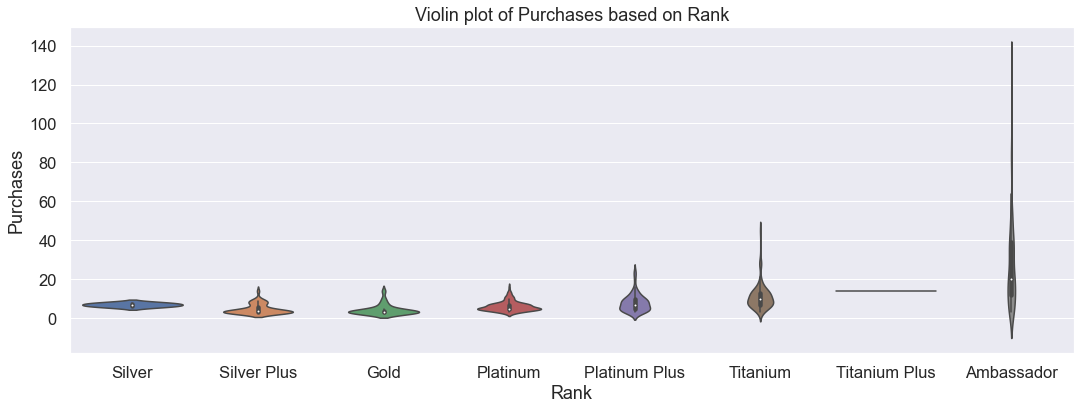

In [40]:
rank_order = ['Silver',
            'Silver Plus',
            'Gold',
            'Platinum',
            'Platinum Plus',
            'Titanium',
            'Titanium Plus',
            'Ambassador']

rank_df = df_merged.copy()
# Calculate median for each rank group
print("Median number of Purchases by Rank")
display(rank_df.groupby("Rank")["Purchases"].median().reindex(rank_order))
print("Max number of Purchases by Rank")
display(rank_df.groupby("Rank")["Purchases"].max().reindex(rank_order))

plt.figure(figsize=(18,6))
ax = sns.violinplot(x="Rank", y="Purchases", data=df_merged, order=rank_order)
plt.title("Violin plot of Purchases based on Rank")
plt.show()

### 7.2 Rank vs Incidence rate and R rate

On the other hand, it is less certain whether there is a clear trend between Rank and Incidence rate or Rank and R rate. Therefore, Rank is a moderate indicator on the amount of rework a doctor generates.

In [41]:
# Calculate median for each rank group
display(rank_df.groupby("Rank")["Incidence rate"].median().reindex(rank_order))
display(rank_df.groupby("Rank")["R rate"].median().reindex(rank_order))

Rank
Silver           7.0
Silver Plus      3.0
Gold             3.0
Platinum         5.0
Platinum Plus    4.0
Titanium         4.0
Titanium Plus    2.5
Ambassador       4.0
Name: Incidence rate, dtype: float64

Rank
Silver           1.13
Silver Plus      0.33
Gold             1.00
Platinum         1.25
Platinum Plus    1.25
Titanium         1.20
Titanium Plus    1.64
Ambassador       0.85
Name: R rate, dtype: float64

## 8. Conclusion

From our analysis in 3.2 we consider that grouping doctors by geography is a poor predictor of the number of purchases a doctor will make or their support needs. In addition, there is no relationship between number of purchases and number of complaints as seen in 3.3.

We move to use a data-centric approach to segment the doctors by using unsupervised machine learning to cluster them based on their features from the tables `Doctors`, `Orders`, `Complaints`, `Instructions`. The model we use for clustering is KMeans and it has grouped the doctors into 5 clusters as seen in section 6. We find that `Rank` impacts the new segmentation strategy the most and also detect a positive relationship between `Rank` and `Purchases`.

**Clusters based on Rank:**
- Silver, Silver Plus, Gold
- Gold Plus, "Platinum
- Platinum Plus, Titanium
- Titanium Plus, Ambassador
- Missing

In conclusion, we recommend the company to base their marketing efforts and customer services based on `Rank`, which is their internal ranking system. 

**Weaknesses:**
- Though it is unknown how a doctor's `Rank` is generated. While, it is a good predictor for the number a doctor will make, it is not a direct indicator of their support needs.
- While Ordinal encoding of Rank captured the ordering of the variable, it assumes that each rank is of equal distance to each other. Perhaps the gap between Titanium and Titanium Plus is small, however the jump to Ambassador is much larger etc. and the encoding does not represent that. 

### 8.1 Next steps

To build upon this analysis, we recommend doing the following:
- Understand how `Rank` is generated
- More data collection to address data imbalance, and reduce proportion of missing values.
- Further feature engineering and selection, e.g. explore other ways of imputing missing values.
- Explore different clustering models besides KMeans. Drawbacks to KMeans include being unable to handle noisy data and outliers, as well as not being suitable to identify clusters with non-convex shapes.
- Alternatives to interpreting the clusters (our approach was using a Random Forest Classifier)